# Vehicle detection
###  Bo Fan

## Import Libraries

In [2]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import time
import cv2
import glob
%matplotlib inline

## Load training data

In [3]:
car_imgs = glob.glob('training_set/vehicles/**/*.png')
noncar_imgs = glob.glob('training_set/non-vehicles/**/*.png')
print(len(car_imgs), len(noncar_imgs))

8792 8968


## Visualize vehicle and non-vehicle objects

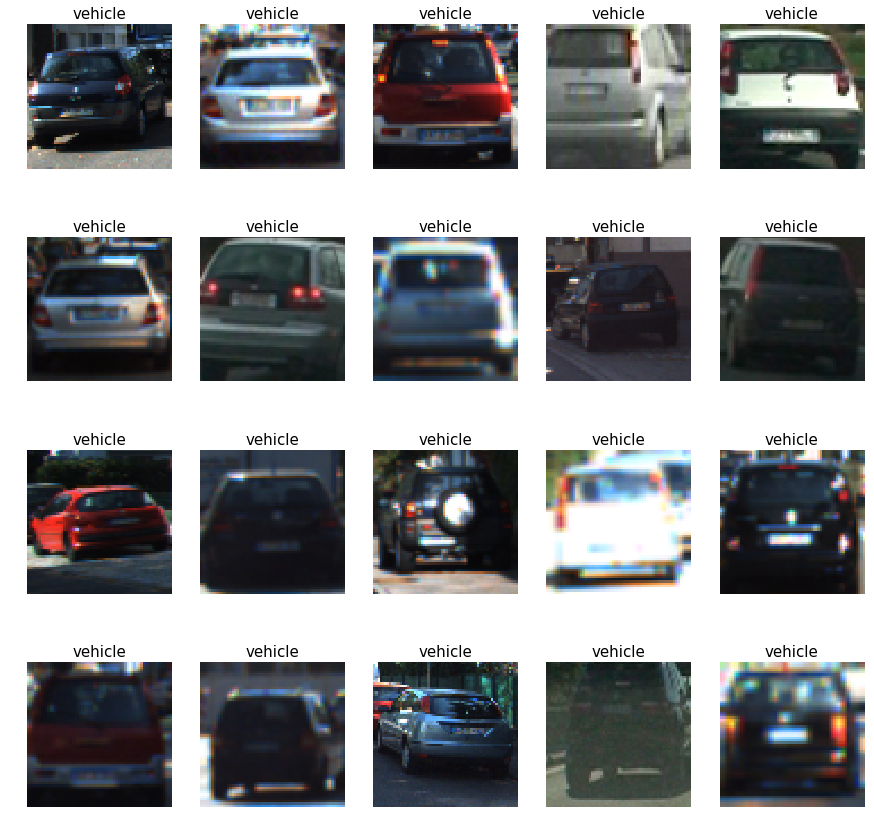

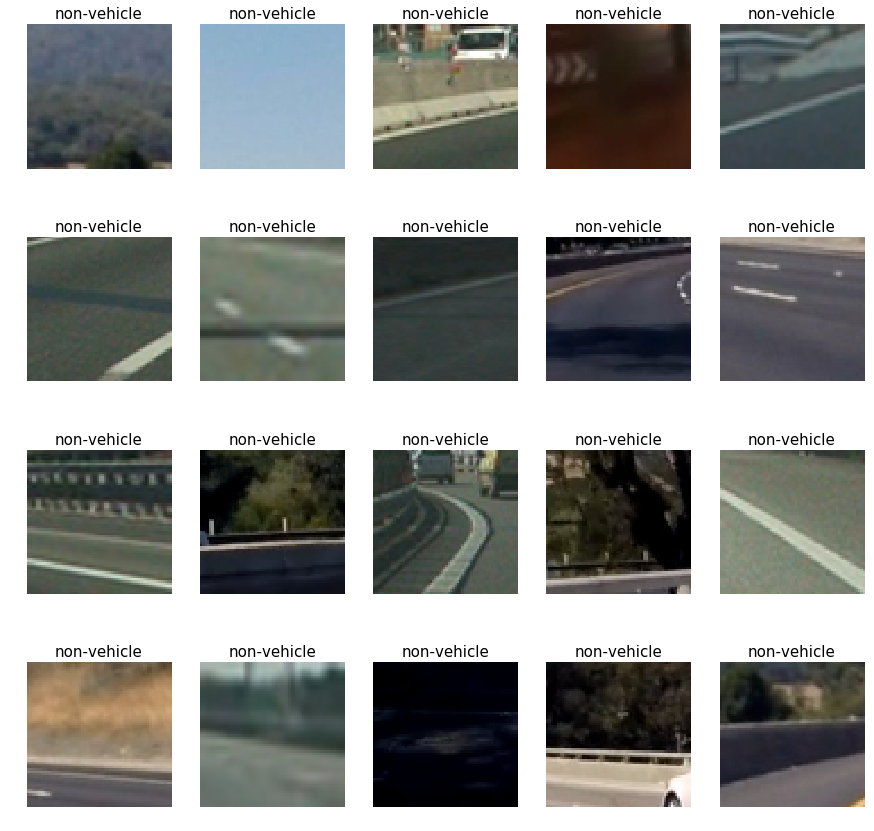

In [4]:
num_rows = 4
num_cols = 5
def show_imgs(imgs, num_rows, num_cols, text):
    fig, axs = plt.subplots(num_rows,num_cols, figsize=(15, 15))
    axs = axs.ravel()
    for i in np.arange(num_rows * num_cols):
        img = cv2.imread(imgs[np.random.randint(0,len(imgs))])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title(text, fontsize=15)
        axs[i].imshow(img)

show_imgs(car_imgs, num_rows, num_cols, 'vehicle')
show_imgs(noncar_imgs, num_rows, num_cols, 'non-vehicle')

## Show HOG images

Text(0.5,1,'Non-Vehicle HOG Image')

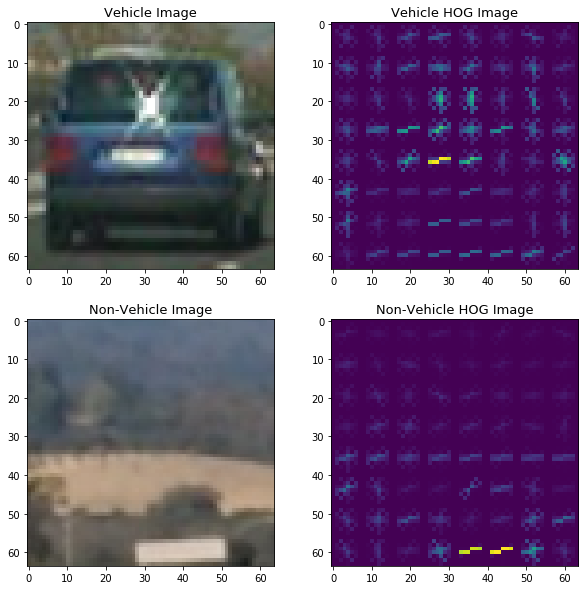

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec):
    # Call with two outputs if vis==True
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
##

idx = 200
car_img = mpimg.imread(car_imgs[idx])
noncar_img = mpimg.imread(noncar_imgs[idx])
orient = 9
pix_per_cell = 8
cell_per_block = 2
vis = True
feature_vec = True


_, car_hogimg = get_hog_features(car_img[:,:,2], orient, pix_per_cell, 
                                   cell_per_block, vis, feature_vec)




_, noncar_hogimg = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, 
                                   cell_per_block, vis, feature_vec)


_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.imshow(car_img)
ax1.set_title('Vehicle Image', fontsize=13)
ax2.imshow(car_hogimg)
ax2.set_title('Vehicle HOG Image', fontsize=13)

ax3.imshow(noncar_img)
ax3.set_title('Non-Vehicle Image', fontsize=13)
ax4.imshow(noncar_hogimg)
ax4.set_title('Non-Vehicle HOG Image', fontsize=13)


In [6]:
def get_hog_features_imgs(imgs, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel_idx):
    # extract hog features for a sequence of images
    features = []
    vis = False
    feature_vec = True
    for imgpath in imgs:
        img = mpimg.imread(imgpath)
        #print (imgpath)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)   
        if hog_channel_idx != 'all':          
            hog_features = get_hog_features(feature_image[:,:,hog_channel_idx], orient, 
                            pix_per_cell, cell_per_block, vis, feature_vec)
        else:
            hog_features = []  
            for idx in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,idx], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis, feature_vec))
            hog_features = np.ravel(hog_features)  
        # print (len(hog_features))
        features.append(hog_features)
    return features
        
        

## Generate training and testing sets

In [9]:
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel_idx = 'all' # Can be 0, 1, 2, or "all"

car_hog_features = get_hog_features_imgs(car_imgs, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel_idx)

noncar_hog_features = get_hog_features_imgs(noncar_imgs, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel_idx)
X = np.vstack((car_hog_features, noncar_hog_features)).astype(np.float64) 
y = np.hstack((np.ones(len(car_hog_features)), np.zeros(len(noncar_hog_features))))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        test_size = 0.15, random_state = np.random.randint(0, 100))



## Train a classifier

In [10]:
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
n_pred = 20
print('SVC prediction results: ', svc.predict(X_test[0:n_pred]))
print('For',n_pred, 'labels: ', y_test[0:n_pred])


Test Accuracy of SVC =  0.9835
SVC prediction results:  [0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.]
For 20 labels:  [0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.]


In [94]:
X_train.shape

(13320, 1188)

## Sliding window

In [11]:
def rgb_tocspace(img, cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            #print ('go into yuv')
        elif cspace == 'YCrCb':
            ctrans = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        ctrans = np.copy(img)  
    return ctrans

In [12]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel_idx, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    rectangles = []
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = rgb_tocspace(img_tosearch, cspace)
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        #print (type(imshape))
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), 
                                                       np.int(imshape[0]/scale)))
        
    if hog_channel_idx != 'all':
        ch1 = ctrans_tosearch[:,:,hog_channel_idx]
    else:
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = False)   
    if hog_channel_idx == 'all':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis = False,feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis = False,feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb*cells_per_step
            ypos = yb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            if hog_channel_idx == 'all':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            test_prediction = svc.predict(hog_features.reshape(1,-1))
                        

            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

## Test on one image with one scale

3 rectangles found in image


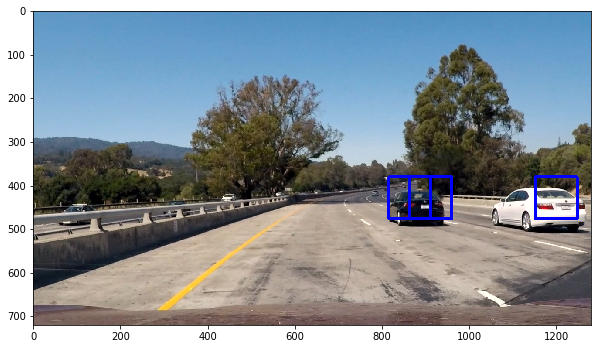

In [13]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 380
ystop = 650
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel_idx = 'all' 

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel_idx, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


## Test on one image with 3 scales

[((64, 460), (96, 492)), ((384, 412), (416, 444)), ((816, 444), (848, 476)), ((832, 460), (864, 492)), ((848, 428), (880, 460)), ((864, 412), (896, 444)), ((864, 428), (896, 460)), ((880, 444), (912, 476)), ((912, 428), (944, 460)), ((1072, 428), (1104, 460)), ((1088, 412), (1120, 444)), ((1104, 412), (1136, 444)), ((1136, 380), (1168, 412)), ((1152, 428), (1184, 460)), ((1168, 428), (1200, 460)), ((1168, 444), (1200, 476)), ((1184, 444), (1216, 476)), ((1200, 412), (1232, 444)), ((1200, 444), (1232, 476)), ((832, 412), (896, 476)), ((864, 412), (928, 476)), ((1152, 412), (1216, 476)), ((832, 384), (960, 512)), ((1024, 384), (1152, 512)), ((1088, 384), (1216, 512)), ((1152, 384), (1280, 512))]


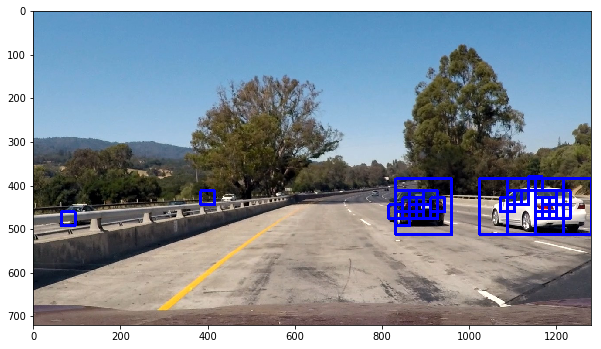

In [14]:
rectangles = [] # reset the rectangles when rerun this cell
paras = [[380, 500, 0.5], [380, 500, 1.0], [320, 620, 2.0]]
for i in range(len(paras)):
        ystart, ystop, scale = paras[i][0], paras[i][1], paras[i][2]
        # print (ystart, ystop, scale)
        rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel_idx, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
        
rectangles = [item for sublist in rectangles for item in sublist] 

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print (rectangles)

## Display heatmap for one image

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        #print (box)
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         print (type(box[0][0]))
#         print (box[0][1], box[1][1],box[0][0],box[1][0])
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        rects.append(bbox)
    # Return the image and final rectangles
    return img, rects


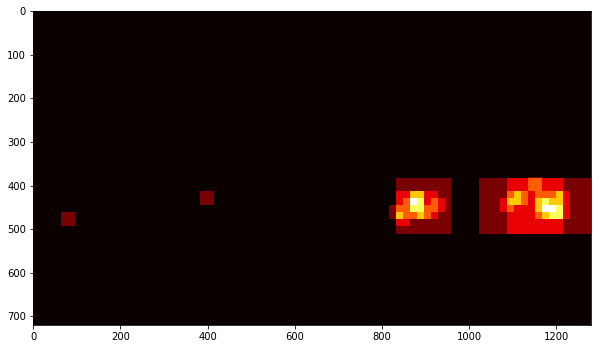

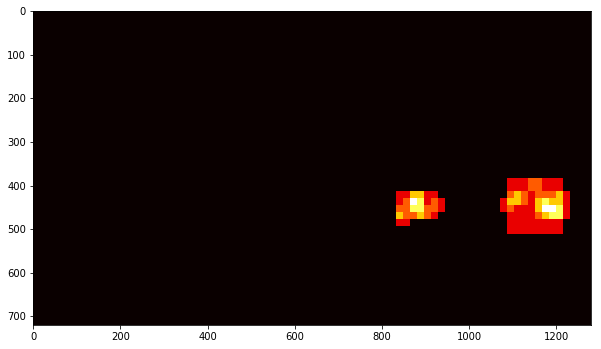

In [16]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


2 cars found


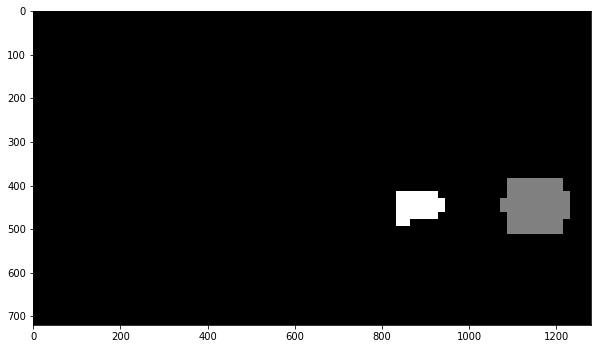

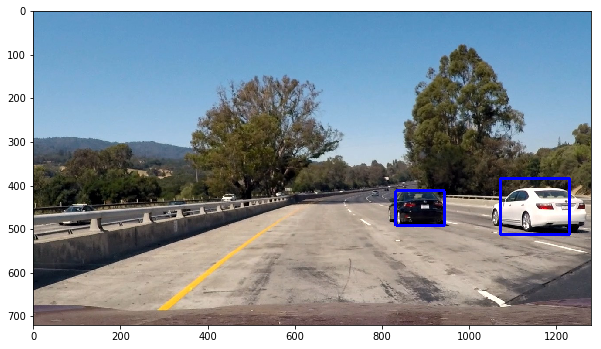

In [17]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

## Test on image sequence

In [32]:
def process_frame(img):
    # processing pipeline without using recent frames
    rectangles = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel_idx = 'all' # Can be 0, 1, 2, or "ALL"
    inputpara = [[400, 465, 1.0], [415, 480, 1.0], [400, 495, 1.5],[432, 528, 1.5], 
             [400, 528, 2.0],[432, 560, 2.0], [400, 595, 3.5], [465, 660, 3.5]]
#     inputpara = [[400, 464, 1.0], [416, 480, 1.0], [400, 496, 1.5],[432, 528, 1.5], 
#                  [400, 528, 2.0],[432, 560, 2.0], [400, 596, 3.5], [464,660,3.5]]
#     rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
#                            orient, pix_per_cell, cell_per_block, None, None))

    for i in range(len(inputpara)):
        ystart2, ystop2, scale2 = inputpara[i][0], inputpara[i][1], inputpara[i][2]
        # print (ystart, ystop, scale)
        rectangles.append(find_cars(img, ystart2, ystop2, scale2, colorspace, hog_channel_idx, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


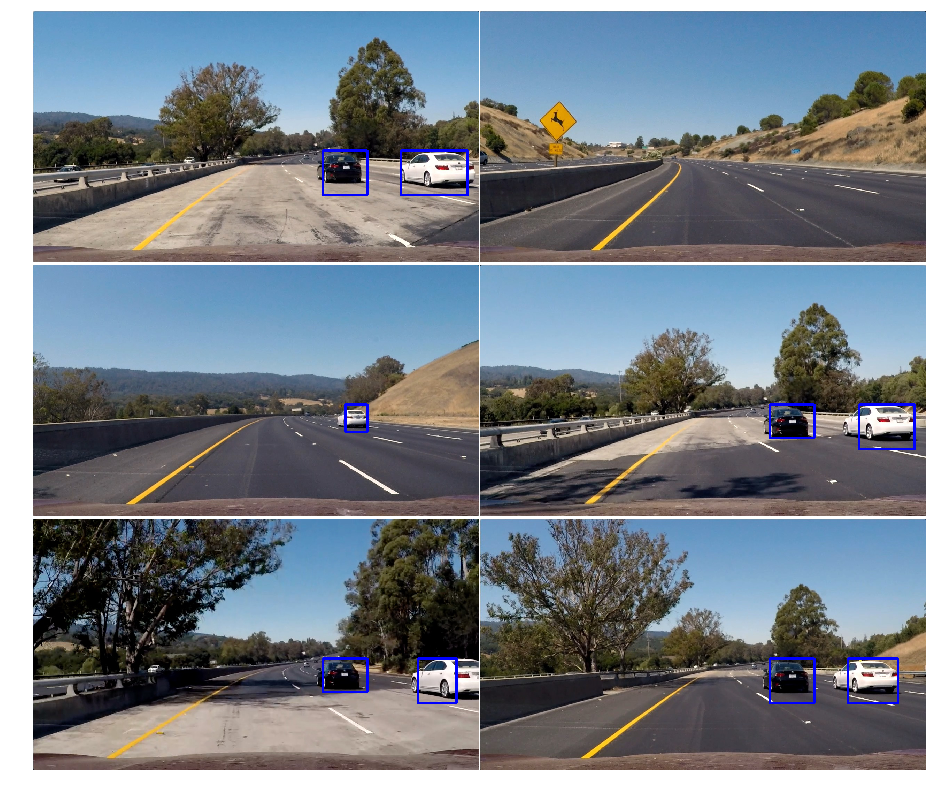

In [19]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

## Test on the video

In [31]:
class Vehicle():
    def __init__(self):
        self.recent_rects = []
        self.max_frames = 15
    def add_rects(self, rects):
        self.recent_rects.append(rects)
        if len(self.recent_rects) > self.max_frames:
            self.recent_rects = self.recent_rects[len(self.recent_rects)-self.max_frames:]
    
def process_videos(img):
    rects = []
#     paras = [[400, 470, 1.0], [420, 480, 1.0], [400, 495, 1.5], [435, 530, 1.5],  # for long video
#              [400, 530, 2.0], [430, 565, 2.0], [400, 600, 3.5], [465, 660, 3.5], [380, 470, 0.8]]
#     paras = [[400, 470, 1.0], [420, 480, 1.0], [400, 495, 1.5], [435, 530, 1.5],  # for short video
#              [400, 530, 2.0], [430, 565, 2.0]]

    paras = [[400, 465, 1.0], [415, 480, 1.0], [400, 495, 1.5],[432, 528, 1.5], 
             [400, 528, 2.0],[432, 560, 2.0], [400, 595, 3.5], [465, 660, 3.5]]
    
    hog_channel_idx = 'all'
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2


    for i in range(len(paras)):
        ystart, ystop, scale = paras[i][0], paras[i][1], paras[i][2]
        # print (ystart, ystop, scale)
        rects.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel_idx, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
        
    rects = [item for sublist in rects for item in sublist] 
    if len(rects) > 0:
        my_vehicles.add_rects(rects)
        
    heatmap0 = np.zeros_like(img[:,:,0])
    for rect in my_vehicles.recent_rects:
        heatmap0 = add_heat(heatmap0, rect)
    heatmap0 = apply_threshold(heatmap0,  1+len(my_vehicles.recent_rects)//2)
    labels = label(heatmap0)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


In [35]:
def write_to_files(inputname, outputname, mode):
    if mode != 'recent':  # use the recently collected frames when computing heatmap
        clip_test = VideoFileClip(inputname)
        clip_test_out = clip_test.fl_image(process_frame)
        %time clip_test_out.write_videofile(outputname, audio=False)
    else: # use current frame for computing heatmap
        clip_test = VideoFileClip(inputname)
        clip_test_out = clip_test.fl_image(process_videos)
        %time clip_test_out.write_videofile(outputname, audio=False)

In [36]:
my_vehicles = Vehicle()
write_to_files('project_video.mp4', 'out_project_video_recent2.mp4', 'recent')

[MoviePy] >>>> Building video out_project_video_recent2.mp4
[MoviePy] Writing video out_project_video_recent2.mp4



 12%|█▏        | 152/1261 [00:41<05:46,  3.20it/s]


 24%|██▍       | 303/1261 [01:22<04:08,  3.85it/s]


 36%|███▌      | 454/1261 [02:02<03:33,  3.77it/s]


 48%|████▊     | 605/1261 [02:45<02:58,  3.68it/s]


 60%|█████▉    | 756/1261 [03:29<02:39,  3.17it/s]


 72%|███████▏  | 907/1261 [04:13<02:07,  2.79it/s]


 84%|████████▍ | 1057/1261 [04:58<01:00,  3.35it/s]


 96%|█████████▌| 1205/1261 [05:41<00:16,  3.37it/s]


100%|█████████▉| 1260/1261 [05:57<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video_recent2.mp4 

CPU times: user 5min 11s, sys: 42.9 s, total: 5min 54s
Wall time: 5min 59s


In [37]:
# use only one frame to compute heatmap each time
my_vehicles = Vehicle()
write_to_files('project_video.mp4', 'out_project_video_recent1.mp4', '')

[MoviePy] >>>> Building video out_project_video_recent1.mp4
[MoviePy] Writing video out_project_video_recent1.mp4



 12%|█▏        | 152/1261 [00:43<05:07,  3.60it/s]


 24%|██▍       | 303/1261 [01:27<04:28,  3.56it/s]


 36%|███▌      | 454/1261 [02:10<03:56,  3.41it/s]


 48%|████▊     | 605/1261 [02:57<03:25,  3.18it/s]


 60%|█████▉    | 756/1261 [03:43<02:48,  2.99it/s]


 72%|███████▏  | 907/1261 [04:27<01:55,  3.06it/s]


 84%|████████▍ | 1057/1261 [05:11<00:56,  3.63it/s]


 96%|█████████▌| 1205/1261 [05:54<00:16,  3.35it/s]


100%|█████████▉| 1260/1261 [06:10<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video_recent1.mp4 

CPU times: user 5min 14s, sys: 48.3 s, total: 6min 2s
Wall time: 6min 11s
